In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")

In [ ]:
def train_helper_data(df):
    recipe_cols = [
        'Cement', 'Blast Furnace Slag', 'Fly Ash', 
        'Water', 'Superplasticizer', 
        'Coarse Aggregate', 'Fine Aggregate'
    ]
    df.columns = df.columns.str.strip() # Clean column names

    # A. Train Helper (Ingredients -> 7-Day Strength)
    print("\n--- Step 1: Training Helper Model ---")
    df_7 = df[df['Age'] == 7].copy()
    
    if len(df_7) == 0:
        print("CRITICAL ERROR: No 7-day data found!")
        return None

    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    helper_model = RandomForestRegressor(n_estimators=100, random_state=42)
    helper_model.fit(X_helper, y_helper)
    print(f"Helper trained on {len(df_7)} rows.")

    # B. Impute Missing 7-Day Data for 28-Day Rows
    print("--- Step 2: Creating Synthetic Pairs ---")
    df_28 = df[df['Age'] == 28].copy()
    
    # Predict 7-day strength for ALL 28-day rows (Synthetic)
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    
    # Merge with real 7-day data if it exists
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index()
    df_7_grouped = df_7_grouped.rename(columns={'Strength': 'Real_Strength_7'})
    
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    
    # Use Real if available, otherwise Synthetic
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    df_augmented['Type'] = np.where(df_augmented['Real_Strength_7'].notna(), 'Real Pair', 'Synthetic Pair')
    
    final_dataset = df_augmented[['Strength_7', 'Strength', 'Type']].copy()
    final_dataset = final_dataset.rename(columns={'Strength': 'Strength_28'})
    
    print(f"Total Training Pairs Created: {len(final_dataset)}")
    return final_dataset

In [ ]:
def process_final_data(df_helper, df_local):
    print("\n" + "="*40)
    print("   TRAINING MAIN SYSTEM")
    print("="*40)

    # A. TRAIN BASE MODEL (The "Lab Curve")
    print("1. Training Base Model on Expanded Data...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    # Train Base Random Forest
    base_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=5, random_state=42)
    base_model.fit(X_train_b, y_train_b)
    
    # Check Accuracy
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE: {mean_absolute_error(y_test_b, base_preds):.2f} MPa")
    print(f"   > Base Model R2 : {r2_score(y_test_b, base_preds):.2f}")

    # B. TRAIN CORRECTION MODEL (The "Weather" Adjuster)
    print("\n2. Training Correction Model on Local Data...")
    
    # Generate Base Predictions
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    # Train Correction Random Forest
    X_corr = df_local[['avgTemp']]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    correction_model = RandomForestRegressor(n_estimators=200, max_depth=3, min_samples_leaf=5, random_state=42)
    correction_model.fit(X_train_c, y_train_c)
    print("   > Correction Model Trained.")

    # C. FINAL VALIDATION
    print("\n3. Validating Full System...")
    
    # Predict on Test Set
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    final_mae = mean_absolute_error(actual_values, final_predictions)
    
    print(f"   > FINAL MAE: {final_mae:.2f} MPa")
    
    # D. VISUALIZATION
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='green', alpha=0.6, label='Predictions')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"Final Model Accuracy (MAE={final_mae:.2f})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # IMPORTANT: Return the models so we can use them later!
    return base_model, correction_model


--- Step 1: Training Helper Model ---
Helper trained on 126 rows.
--- Step 2: Creating Synthetic Pairs ---
Total Training Pairs Created: 425

   TRAINING MAIN SYSTEM
1. Training Base Model on Expanded Data...
   > Base Model MAE: 8.51 MPa
   > Base Model R2 : 0.53

2. Training Correction Model on Local Data...
   > Correction Model Trained.

3. Validating Full System...
   > FINAL MAE: 1.85 MPa


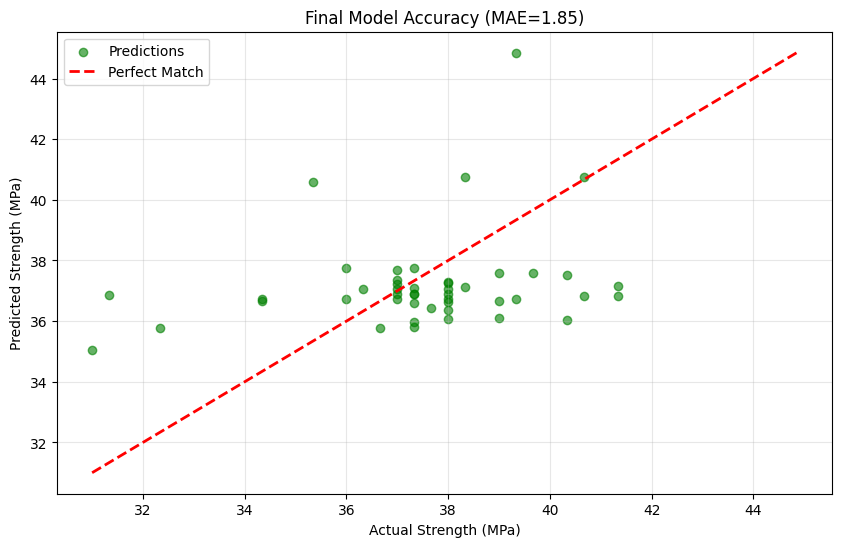

In [ ]:
# --- 4. EXECUTE THE PIPELINE ---

# Step A: Create Helper Data
df_helper = train_helper_data(df_kaggle)

# Step B: Train Models and Capture them into variables
# WE PASS df_local HERE
base_model, correction_model = process_final_data(df_helper, df_local)

In [ ]:
# --- 5. PREDICTION FUNCTION ---
def get_final_prediction(strength_7_val, temp_val):
    """
    Production function to predict 28-day strength.
    """
    # 1. Create Input DataFrames
    input_base = pd.DataFrame([[strength_7_val]], columns=['Strength_7'])
    input_corr = pd.DataFrame([[temp_val]], columns=['avgTemp'])
    
    # 2. Predict
    pred_base = base_model.predict(input_base)[0]
    pred_corr = correction_model.predict(input_corr)[0]
    final_pred = pred_base + pred_corr
    
    # 3. Report
    print(f"\n--- PREDICTION REPORT ---")
    print(f"Inputs:       7-Day={strength_7_val} MPa | Temp={temp_val}°C")
    print(f"Lab Curve:    {pred_base:.2f} MPa")
    print(f"Weather Adj: {pred_corr:+.2f} MPa")
    print(f"FINAL RESULT: {final_pred:.2f} MPa")
    
    return final_pred

In [ ]:
# --- 6. TEST SCENARIOS ---
print("\n--- TEST RUNS ---")
p1 = get_final_prediction(30.0, 30.0) # Hot
p2 = get_final_prediction(25.0, 24.0) # Cold


--- TEST RUNS ---

--- PREDICTION REPORT ---
Inputs:       7-Day=30.0 MPa | Temp=30.0°C
Lab Curve:    35.29 MPa
Weather Adj: +2.76 MPa
FINAL RESULT: 38.05 MPa

--- PREDICTION REPORT ---
Inputs:       7-Day=25.0 MPa | Temp=24.0°C
Lab Curve:    33.18 MPa
Weather Adj: +4.57 MPa
FINAL RESULT: 37.75 MPa
